# PRM 2D Path Planning: Dijkstra vs A*

Step-by-step exploration of roadmap construction, search, shortcutting, and benchmarking using `prm_2d.py`.

## Prerequisites
- Ensure numpy and matplotlib are installed.
- Execute this notebook from the repository root so imports resolve.

In [21]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import pylab as pl

import environment_2d, prm_2d


In [22]:
# Global configuration
seed = 4
np.random.seed(seed)

# Build a random environment and query
env = environment_2d.Environment(10, 6, 5)
query = env.random_query()
if query is None:
    raise RuntimeError('Failed to sample a collision-free start/goal pair.')
x_start, y_start, x_goal, y_goal = query
planning_params = dict(n_samples=800, connection_radius=0.6, max_neighbors=15)
planning_params

{'n_samples': 800, 'connection_radius': 0.6, 'max_neighbors': 15}

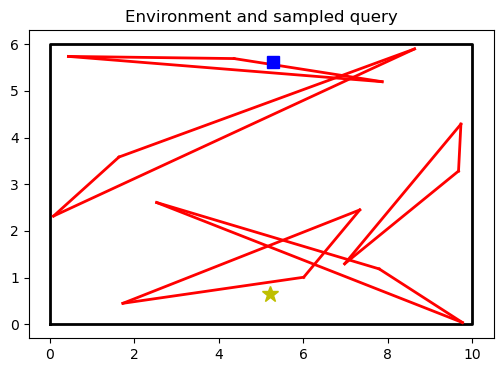

In [23]:
# Visualise environment and query
pl.figure(figsize=(6, 4))
env.plot()
env.plot_query(x_start, y_start, x_goal, y_goal)
pl.title('Environment and sampled query')
pl.show()

In [24]:
# Build a reusable roadmap
planner = prm_2d.ProbabilisticRoadmap2D(**planning_params)
build_stats = planner.build(env, seed=seed)
build_stats

PRMStats(build_time=1.0098249912261963, search_time=0.0, total_samples=800, total_nodes=800, algorithm='dijkstra', path_length=None, expanded_nodes=None)

In [25]:
# Helper to execute one search algorithm and compute its shortcut
def run_algorithm(algo: str):
    path, stats = planner.query(
        (x_start, y_start), (x_goal, y_goal), algorithm=algo)
    shortcut = None
    if path is not None:
        shortcut_candidate = prm_2d.path_shortcutting(
            path,
            env,
            maxrep=400,
            step=planner.collision_check_step,
            seed=seed,
        )
        if shortcut_candidate and len(shortcut_candidate) >= 2:
            shortcut = shortcut_candidate
    return path, shortcut, stats


algorithms = ('dijkstra', 'astar')
results = {algo: run_algorithm(algo) for algo in algorithms}
results

{'dijkstra': ([(5.279088234179204, 5.625429503705652),
   (5.717286703462248, 5.588970788131961),
   (6.217385766172146, 5.5460140598309815),
   (6.769445336676444, 5.649488956651357),
   (7.348779564739258, 5.759205549677707),
   (7.6025190149029145, 5.81084038256308),
   (8.099588857559008, 5.897189817842602),
   (8.411352107115443, 5.971111329446222),
   (8.811185983983851, 5.879969425914128),
   (8.457196852384731, 5.731784918724054),
   (8.187518967322726, 5.507354052270825),
   (7.86795432920024, 5.260658019371684),
   (7.68345378062664, 5.070603985401429),
   (7.254800714984166, 4.944169138939036),
   (6.836360346351704, 4.683923896346695),
   (6.574481372206548, 4.491190438208029),
   (6.067260013610261, 4.446084088598796),
   (5.599579391204445, 4.162571489927089),
   (5.1831832686402315, 4.045693903843667),
   (4.824576005211638, 3.9086444637249507),
   (4.388995408273212, 3.7999217841436828),
   (3.989738923497974, 3.5923184666935972),
   (3.668347403262049, 3.45926968874162

In [26]:
# Summarise metrics in a dataframe
rows = []
for algo, (path, shortcut, stats) in results.items():
    if path is None:
        rows.append(dict(algorithm=algo, status='failed'))
        continue
    raw_len = stats.path_length if stats.path_length is not None else prm_2d.path_length(
        path)
    if shortcut is not None:
        shortcut_len = prm_2d.path_length(shortcut)
        gain_abs = raw_len - shortcut_len
        gain_pct = gain_abs / raw_len * \
            100.0 if raw_len > 1e-9 else float('nan')
    else:
        shortcut_len = float('nan')
        gain_abs = float('nan')
        gain_pct = float('nan')
    rows.append(dict(
        algorithm=algo,
        status='done',
        search_time=stats.search_time,
        path_length=raw_len,
        shortcut_length=shortcut_len,
        gain_abs=gain_abs,
        gain_pct=gain_pct,
        expanded_nodes=stats.expanded_nodes,
    ))
metrics_df = pd.DataFrame(rows).set_index('algorithm')
metrics_df

,status,search_time,path_length,shortcut_length,gain_abs,gain_pct,expanded_nodes
algorithm,,,,,,,
dijkstra,done,0.016268,16.804496,16.185464,0.619032,3.683728,665
astar,done,0.005873,16.804496,16.185464,0.619032,3.683728,524


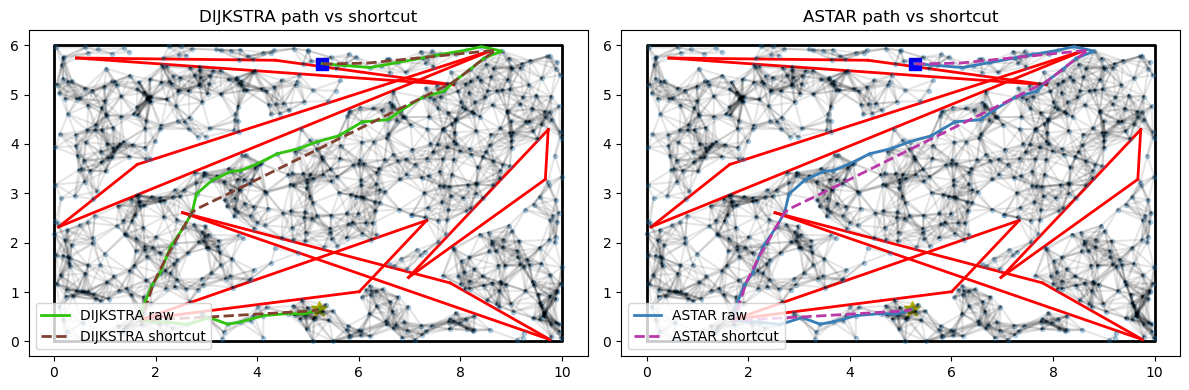

In [31]:
# Plot raw vs shortcut paths for each algorithm in separate subplots
color_map = {'dijkstra': "#30c40c", 'astar': '#377eb8'}
shortcut_map = {'dijkstra': '#814131', 'astar': '#b937a7'}
fig, axes = pl.subplots(1, len(algorithms), figsize=(12, 4))
if len(algorithms) == 1:
    axes = [axes]
for ax, algo in zip(axes, algorithms):
    key = algo.lower()
    path, shortcut, _ = results[algo]
    pl.sca(ax)
    ax.clear()
    env.plot()
    env.plot_query(x_start, y_start, x_goal, y_goal)
    prm_2d._draw_roadmap(planner)
    if path is not None:
        xs, ys = zip(*path)
        ax.plot(xs, ys, color_map.get(key, '#333333'),
                linewidth=2, label=f'{algo.upper()} raw')
    if shortcut is not None:
        xs_s, ys_s = zip(*shortcut)
        ax.plot(xs_s, ys_s, '--', linewidth=2, color=shortcut_map.get(key,
                '#555555'), label=f'{algo.upper()} shortcut')
    ax.set_title(f'{algo.upper()} path vs shortcut')
    ax.legend(loc='best')
fig.tight_layout()
pl.show()

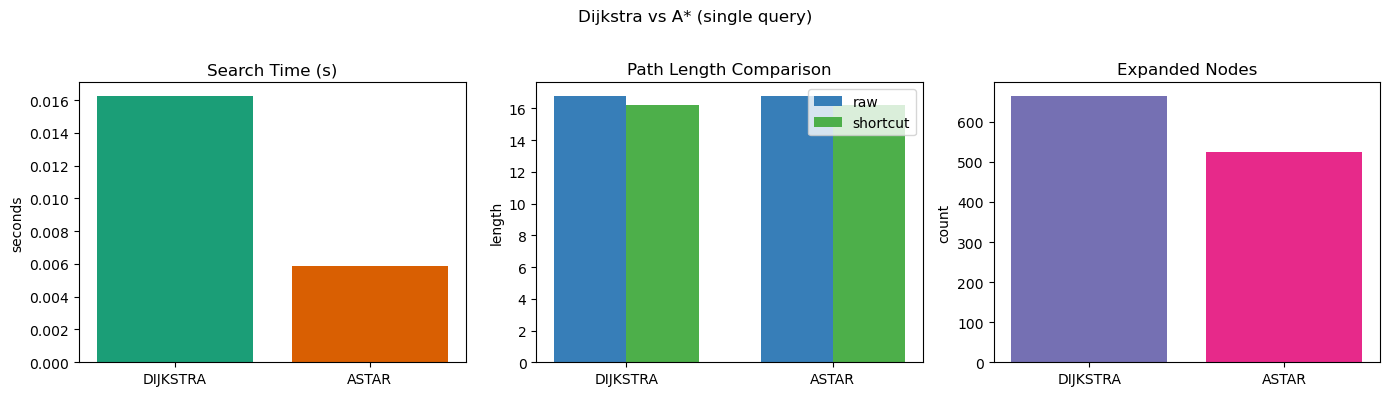

In [28]:
# Compare search time, lengths, and expansions side by side
labels = [algo.upper() for algo in metrics_df.index]
indices = np.arange(len(labels))
width = 0.35
search_times = metrics_df['search_time'].to_numpy()
raw_lengths = metrics_df['path_length'].to_numpy()
shortcut_lengths = metrics_df['shortcut_length'].to_numpy()
expanded_nodes = metrics_df['expanded_nodes'].fillna(0).to_numpy()

fig, axes = pl.subplots(1, 3, figsize=(14, 4))
axes[0].bar(labels, search_times, color=['#1b9e77', '#d95f02'][: len(labels)])
axes[0].set_title('Search Time (s)')
axes[0].set_ylabel('seconds')

axes[1].bar(indices - width/2, raw_lengths,
            width=width, color='#377eb8', label='raw')
axes[1].bar(indices + width/2, shortcut_lengths,
            width=width, color='#4daf4a', label='shortcut')
axes[1].set_xticks(indices)
axes[1].set_xticklabels(labels)
axes[1].set_title('Path Length Comparison')
axes[1].set_ylabel('length')
axes[1].legend()

axes[2].bar(labels, expanded_nodes, color=[
            '#7570b3', '#e7298a'][: len(labels)])
axes[2].set_title('Expanded Nodes')
axes[2].set_ylabel('count')

for ax in axes:
    ax.set_ylim(bottom=0)

fig.suptitle('Dijkstra vs A* (single query)')
fig.tight_layout(rect=(0, 0, 1, 0.96))
pl.show()


=== PRM Benchmark (algorithm comparison) ===
  Environments x Queries : 3 x 5 (total 15)
  Avg roadmap build      : 1.042 s  | avg nodes: 800.0
  DIJKSTRA -> success: 15/15  avg_time: 0.0072s  avg_length: 6.556 avg_shortcut: 6.216  shortcut_time: 0.1608s  avg_expanded: 393.2
    shortcut gain avg: 3.80%  best: 12.89%  worst: 0.00%
  ASTAR    -> success: 15/15  avg_time: 0.0069s  avg_length: 6.556 avg_shortcut: 6.216  shortcut_time: 0.1762s  avg_expanded: 143.5
    shortcut gain avg: 3.80%  best: 12.89%  worst: 0.00%


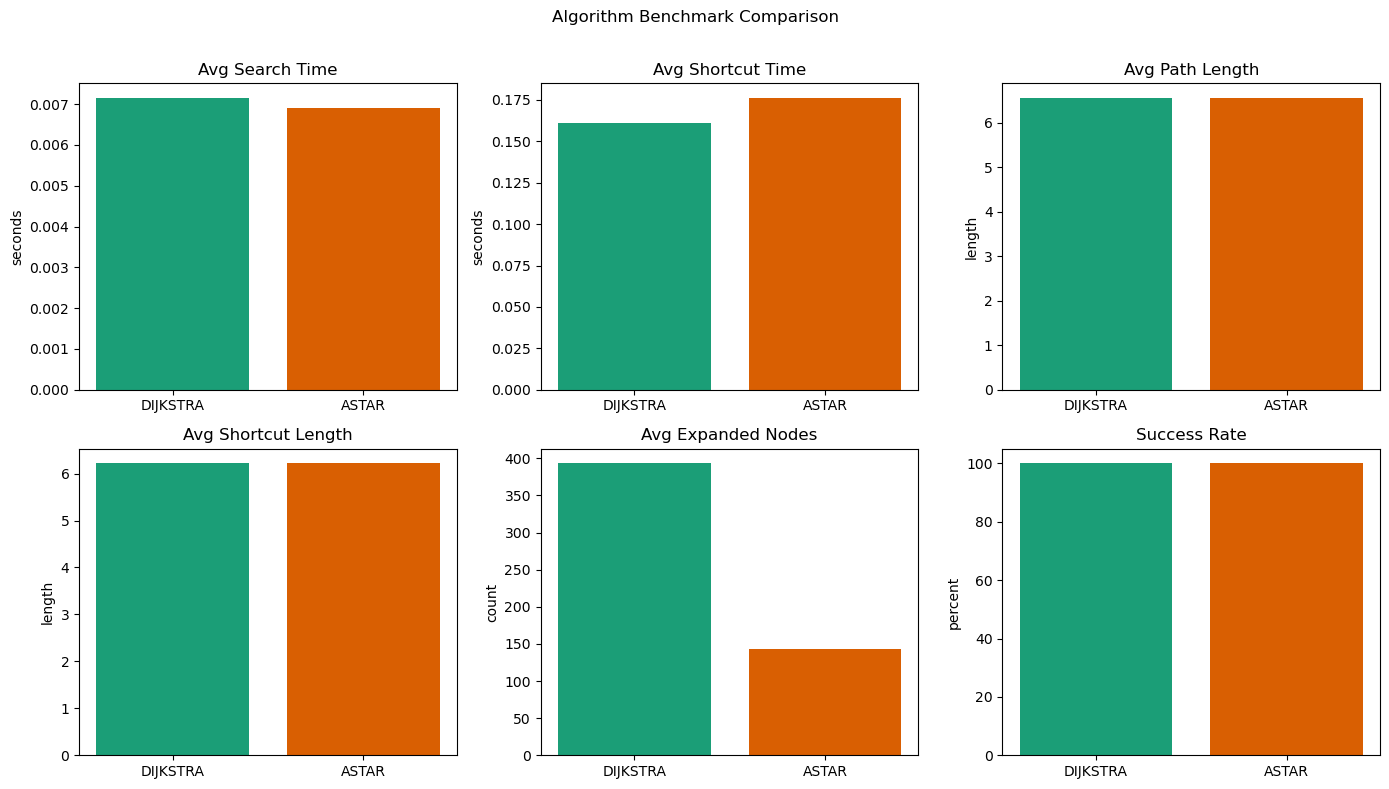

In [29]:
# Batch benchmark with aggregated metrics and plots
prm_2d.benchmark(num_env=3, num_queries=5,
                 algorithms=algorithms, show_hist=True)